Este script es para entrenar el modelo absoluto
con varios conjuntos de datos y probar con el restante 

In [1]:
import os
import pickle
import numpy 
import pandas as pd
#import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pylab import *
from matplotlib import pyplot

from scipy. ndimage import filters
import pandas as pd
import os
from keras.models import Model, Sequential, save_model, load_model
import math
from sklearn.metrics import mean_squared_error

import random
from sklearn.preprocessing import MinMaxScaler
import h5py
import tensorflow as tf


Using TensorFlow backend.


In [2]:
import os 
import pickle
import numpy as np
import random

def preprocess(data_dirs, data_file,name):
    # all_ped_data would be a dictionary with mapping from each ped to their
    # trajectories given by matrix 3 x numPoints with each column
    # in the order x, y, frameId
    # Pedestrians from all datasets are combined
    # Dataset pedestrian indices are stored in dataset_indices
    all_ped_data={}
    dataset_indices=[]
    current_ped = 0
    # For each dataset
    for directory in data_dirs:
        # Define the path to its respective csv file
        #PETS2009-S2L1-mmundo.csv
        #'PETS09-S2L1.txt'
        file_path = os.path.join(directory,name )

        # Cargar datos desde el archivo csv
        # Los datos son una matriz 4x numTrajPoints
        
        
        data = np.genfromtxt(file_path, delimiter=',')
       
        
        # Obtenga el numero de peatones en el conjunto de datos actual
        uni=np.unique(data[:,1])    
        numPeds=np.size(np.unique(data[:,1]))
        
        print("El numero de peatones en"+ directory+" es "+str(numPeds))
        # Para cada peaton en el conjunto de datos
        for ped in range(1, numPeds+1):
            #Son los datos de la persona ped
            traj = data[ data[:, 1] == ped]
            #Esta como (x,y,frame_Id)
            traj = traj[:, [2,3,0]]
            
            #Esta como [[x,...],[y,...],[Frame_Id,..]]
            traj=[list(traj[:,0]),list(traj[:,1]),list(traj[:,2])]
            all_ped_data[current_ped + ped] = np.array(traj)

        # Current dataset done
        dataset_indices.append(current_ped+numPeds)
        current_ped += numPeds

    # Los datos completos son una tupla de todos los datos de peatones y los indices de datos del conjunto de datos.
    complete_data = (all_ped_data, dataset_indices)
    # Almacena los datos completos en el archivo pickle
    f = open(data_file, "wb")
    pickle.dump(complete_data, f, protocol=2)
    f.close()
    return complete_data

In [3]:
def load_preprocessed(data_file,seq_length_obs,batch_size):
    
    # cargar los datos
    f = open(data_file, "rb")
    raw_data = pickle.load(f)
    f.close()

    # Obtengo los peatones
    all_ped_data =raw_data[0]
 
    #all_ped_data es el vector {[[],[],[]],...,[[],[],[]]} tantos como pedestrian hayan
    # No usamos dataset_indices por ahora
    # dataset_indices = self.raw_data[1]

    # Construimos data con secuencias(o trayectorias) del largo than seq_length_obs
    data = []
    counter = 0

    # para cada peaton en data
    for ped in all_ped_data:
        
        #ped es un numero entero y va de 1 hasta la cantidad total de pedestrian
        # Extract his trajectory
        traj = all_ped_data[ped]
           
        #print(traj.shape)
        # If the length of the trajectory is greater than seq_length (+2 as we need both source and target data)
        #solo se toman las trajectorias de longitud mayor a seq_length+2
        if traj.shape[1] >= (seq_length_obs+1):
            # TODO: (Improve) Store only the (x,y) coordinates for now
            
            #print(traj[[0, 1], :].shape)
            data.append(traj[[0, 1], :].T)
            #print(traj[[0, 1], :].T)
            # Number of batches this datapoint is worth
            #print(traj.shape[1] )
            #print(int(traj.shape[1] / ((seq_length_obs+1))))
            counter += int(traj.shape[1] / ((seq_length_obs+1)))
        
    # Calculate the number of batches (each of batch_size) in the data
    #counter tiene la cantidad de bloques de 8 pasos
        
    num_batches = int(counter /batch_size)
    #cada bache tiene batch_size conjuntos donde cada conjunto tiene datos de length+2
    return data,num_batches

In [6]:


data_dirs = ['../data1/ucy/zara/zara02','../data1/ucy/zara/zara01',
             '../data1/ucy/univ','../data1/eth/hotel','../data1/eth/univ']

dim_image = [[720,576],[720,576],[720,576],[720,576],[640,480]]

# aqui se pone indice del dataset que va a ser el de prueba
indice_test = 4

image_size = dim_image[indice_test]

datasets = range(5)
datasets = list(datasets)
datasets.remove(indice_test)

used_data_dirs = [data_dirs[x] for x in datasets]

#Directorio de datos donde reside el archivo pickle preprocesado
data_dir = '../data1'

#Defina la ruta del archivo en el que deben almacenarse los datos.
data_file = os.path.join(data_dir, "datos_limpios_.cpkl")

name ='pixel_pos.csv'

#print(used_data_dirs)
data = preprocess(used_data_dirs, data_file,name)
datos,numero = load_preprocessed(data_file,8,1)
print("El numero de muestras es de "+str(numero))

El numero de peatones en../data1/ucy/zara/zara02 es 204
El numero de peatones en../data1/ucy/zara/zara01 es 148
El numero de peatones en../data1/ucy/univ es 434
El numero de peatones en../data1/eth/hotel es 390
El numero de muestras es de 3832


In [7]:
def secuencia(seq_length_obs,data):  
    tamano=int(len(data))
    
    X,Y=[],[]
    for j in range(tamano):
        traj = data[j]
        lon = traj.shape[0]-seq_length_obs
    #lon=data.shape[0]-seq_length_obs-seq_length_pred
        for i in range(0,lon):
            a = traj[i:(i +seq_length_obs ), :]
            X.append(a)
            b = traj[i +seq_length_obs,:]
            Y.append(b)
    return np.array(X),np.array(Y)

## Visualizacion de los datos de entrenamiento

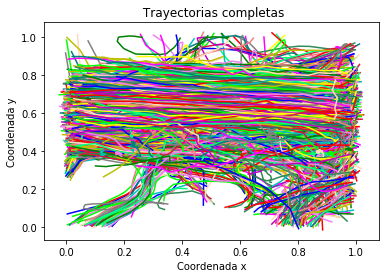

In [8]:
# import random
color_names = ["r","crimson" ,"g", "b","c","m","y","lightcoral", "peachpuff","grey","springgreen" ,"fuchsia","violet","teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]

for i in range(len(datos)):
    cpu = random.choice(range(17))
    pintar = plt.plot(datos[i][:,0],datos[i][:,1],color=color_names[cpu])
plt.title(" Trayectorias completas") 
plt.xlabel("Coordenada x")   
plt.ylabel("Coordenada y") 

#plt.savefig("trayectorias.jpg")
plt.show() 

# Datos para entrenamiento

In [ ]:
length_obs = 8
trainX,trainY = secuencia(length_obs,datos)

In [ ]:
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1],trainX.shape[2]))

In [ ]:
data_shape = trainX.shape[1:]
print(data_shape)
import numpy as np
np.shape(trainX)

# Se diseña la red

In [ ]:
from keras.models import Sequential
from keras import optimizers
#from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dense
from keras.layers import LSTM
#from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
from datetime import datetime
from keras.utils import plot_model



if 'model' in globals(): del model
model = None
model = Sequential()
model.add(LSTM(9, return_sequences=True, input_shape=data_shape, name='lstm1'))
model.add(LSTM(9, name='lstm2'))
model.add(Dense(2))

In [ ]:
model.summary()

In [ ]:
#validation_data=(vali_obs, vali_pred),
opt = optimizers.RMSprop(lr = 0.006, decay=1e-2)
model.compile(optimizer=opt, loss='logcosh',metrics=['mse'])
history= model.fit(trainX, trainY, epochs=100, batch_size=16, verbose=2)
#plot_model(model, show_shapes=True, to_file='modelo.png')

In [ ]:
history_dict= history.history
history_dict.keys()

In [ ]:
acc = history.history['mean_squared_error']
#val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

# figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b', label='Training loss')
#plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training mse')
#plt.plot(epochs, val_acc, 'g', label='Validation mse')
plt.title('Training mse')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Modelos de ETH y UCY se entrenan con 4 y se prueba con el restante

In [ ]:
#model.save('lstm-xy-ucy-univ.h5')

In [ ]:
#model.save('lstm-xy-eth-hotel.h5')

In [ ]:
#model.save('lstm-xy-ucy-zara-zara01.h5')

In [ ]:
#model.save('lstm-xy-ucy-zara-zara02.h5')

In [ ]:
#model.save('lstm-xy-eth-univ.h5')

# Aqui se carga el modelo con el cual vamos a predecir

In [10]:
modelxy = load_model('lstm-xy-eth-univ.h5')

# Aqui se carga el dataset que es el de test

In [11]:
dataset_test=[indice_test]

used_data_dirs = [data_dirs[x] for x in dataset_test]
#Directorio de datos donde reside el archivo pickle preprocesado
data_dir = '../data1'

#Defina la ruta del archivo en el que deben almacenarse los datos.
data_file = os.path.join(data_dir, "datos_limpios_prueba.cpkl")

name ='pixel_pos.csv'
# If the file doesn't exist already or if forcePreProcess is true
#se usa preprocesscsv para los csv y preprocess para el .txt

#print(used_data_dirs)
data1 = preprocess(used_data_dirs, data_file,name)

# la segunda entrada es la suma de obs + pred
datos_prueb,numero = load_preprocessed(data_file,12,1)

El numero de peatones en../data1/eth/univ es 360


# PREDICCION

 ## Errores para medir las trayectorias predichas

In [12]:
def error_promedio(predicted_traj, true_traj, observed_length):
    
    error = np.zeros(len(true_traj) - observed_length)
    # PARA CADA PUNTO EN LA TRAYECTORIA PREDICHA
    for i in range(observed_length, len(true_traj)):
        # The predicted position
        pred_pos = predicted_traj[i]
        # The true position
        true_pos = true_traj[i]

        # The euclidean distance is the error
        error[i-observed_length] = np.linalg.norm(true_pos - pred_pos)

    # Return the mean error
    return np.mean(error)


In [13]:
def error_desplazamiento_final(predicted_traj, true_traj):
    tam = len(predicted_traj)
    return np.linalg.norm(predicted_traj[tam-1]-true_traj[tam-1])

In [14]:
#esta funcion construye secuencias con solo la parte observada y secuencias completa
# es decir secuencia de longitud obs+pred

def secuencia_pred(seq_length_obs,data,seq_length_pred):
    
    tamano = int(len(data))
    X,Y_true = [],[]
    # se recorre todo los datos de test
    for j in range(tamano):
        traj = data[j]
        
        lon = traj.shape[0]-seq_length_obs-seq_length_pred
        #lon=data.shape[0]-seq_length_obs-seq_length_pred
        for i in range(0,lon+1):
            a = traj[i:(i +seq_length_obs ), :]
            
            X.append(a)
            # esta parte tiene tanto la parte observada como 
            b = traj[i: (i+seq_length_obs+seq_length_pred), :]
        
            Y_true.append(b)
    return np.array(X),np.array(Y_true)

In [15]:
# Esta funcion predice posiciones pred normalizados

def sample(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_pred(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    todo=[]
    
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        #print(Y_true[i])
        
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modelxy.predict(traj_obsr)
            next_point = predict
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
            
        diff=Y_true[i][seq_length_obs:]-traj_pred[seq_length_obs:]
        diff=diff**2
        diff=np.sqrt(np.sum(diff,axis=1))
        todo.append(diff)
    
        total_error +=  error_promedio(traj_pred , Y_true[i], seq_length_obs)
        total_final += error_desplazamiento_final(traj_pred, Y_true[i])
        
        
    #print(todo)
    error_ade_modelo = total_error/len(X)
    error_fde_modelo = total_final/len(X)
    
    ade=[t for o in todo for t in o]
    
    print('---------Error--------')
    print('ADE')
    print(np.mean(ade))

    print(error_ade_modelo)
    print('FDE')
    print(error_fde_modelo)
        

In [16]:
# Esta funcion hace la prediccion en coordenadas pixel
def sample_en_pixeles(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_pred(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    todo = []
    
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        #print(Y_true[i])
        
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modelxy.predict(traj_obsr)
            next_point = predict
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
        
        traj_pre =  np.column_stack((image_size[0]*traj_pred[:,0],image_size[1]*traj_pred[:,1]))
        traj_tr = np.column_stack((image_size[0]*Y_true[i][:,0],image_size[1]*Y_true[i][:,1]))
          
        diff = traj_pre[seq_length_obs:]-traj_tr[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        todo.append(diff)
        
        total_error += error_promedio(traj_pre , traj_tr, seq_length_obs)
        total_final += error_desplazamiento_final(traj_pre, traj_tr)
             
    error_modelo = total_error/len(X)
    error_fde_modelo = total_final/len(X)
    
    ade=[t for o in todo for t in o]
    
    print('---------Error--------')
    print('ADE')
    print(np.mean(ade))
    
    print('Error promedio')
    print(error_modelo)
    print('FDE')
    print(error_fde_modelo)     

In [17]:
sample(datos_prueb,8,2)

---------Error--------
ADE
0.01673091319909863
0.016730913199098613
FDE
0.020281104509136345


In [18]:
sample_en_pixeles(datos_prueb,8,2)

---------Error--------
ADE
9.27351903653013
Error promedio
9.273519036530155
FDE
11.267888746551032


# Las 8 primeras posiciones de todos los peatones del conjunto de test

In [19]:
def secuencia_x_persona(seq_length_obs,data,seq_length_pred):
    tamano = int(len(data))
    X,Y_true = [],[]
    for j in range(tamano):
        traj = data[j]
        X.append(traj[0:seq_length_obs,:])
        Y_true.append(traj[0:seq_length_obs+seq_length_pred,:])
    return np.array(X),np.array(Y_true)

In [20]:
def sample_x_persona_normalizado(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_x_persona(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    plt.figure(figsize=(18,15)) 
    color_names = ["r","crimson" ,"g", "b","c","m","y","lightcoral", "peachpuff","grey","springgreen" ,"fuchsia","violet","teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]

    todo = []
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modelxy.predict(traj_obsr)
            next_point = predict
          
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
        
        diff = Y_true[i][seq_length_obs:]-traj_pred[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        
        todo.append(diff)
        error_prom = error_promedio(traj_pred ,Y_true[i], seq_length_obs)
        FDE = error_desplazamiento_final(traj_pred , Y_true[i])
        

        print("TRAYECTORIA PREDICHA DEL PEATON ",i+1)
        print(traj_pred)
        print("TRAYECTORIA VERDADERA  ")
        print(Y_true[i])
        print("EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = {:.3f} ".format(error_prom))
        print("ERROR DE DESPLAZAMIENTO FINAL ES ={:.3f}".format(FDE))
                         
        cpu = random.choice(range(17))
                         
        subplot(1,1,1)
        
        
        #predicha=plt.plot(X[i][:,0],X[i][:,1],'*--',color=color_names[cpu])
        predicha=plt.plot(Y_true[i][0:seq_length_obs,0],Y_true[i][0:seq_length_obs,1],'*--',color=color_names[cpu],label = 'Observado')
        predicha=plt.plot(Y_true[i][seq_length_obs-1:,0],Y_true[i][seq_length_obs-1:,1],'--',color=color_names[cpu],label = 'GT')
        predicha=plt.plot(traj_pred[seq_length_obs-1:,0],traj_pred[seq_length_obs-1:,1],'-',color=color_names[cpu],label = 'Predicho')
        plt.title("Cuatro posiciones predichas con LTM-X-Y") 
        #plt.legend()
        plt.xlabel('Coordenada x')
        plt.ylabel('Coordenada y')
        
        
        total_error += error_prom
    ade=[t for o in todo for t in o]
    error_modelo = total_error/len(X)
    print("EL ERROR PROMEDIO DE TODA LA PREDICCIÓN")
    print(error_modelo)
    print("Error ade")
    print(np.mean(ade))
    #plt.savefig("4predichas-simpli.pdf")
    plt.show()

In [21]:
def sample_x_persona_pixeles(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_x_persona(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    plt.figure(figsize=(18,15))  
    color_names = ["r", "g", "b","c","m","y", "peachpuff","grey", "fuchsia","violet",
                   "teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]
    todo=[]
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            #print(traj_obsr)
            predict = modelxy.predict(traj_obsr)
            next_point = predict
          
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
    
    
        traj_pre =  np.column_stack((image_size[0]*traj_pred[:,0],image_size[1]*traj_pred[:,1]))
        traj_tr = np.column_stack((image_size[0]*Y_true[i][:,0],image_size[1]*Y_true[i][:,1]))
       
        
        diff = traj_tr[seq_length_obs:]-traj_pre[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        
        todo.append(diff)
        error_prom = error_promedio(traj_pre , traj_tr, seq_length_obs)
        FDE = error_desplazamiento_final(traj_pre , traj_tr)
        
    

        print("TRAYECTORIA PREDICHA DEL PEATON ",i+1)
        print(traj_pre)
        print("TRAYECTORIA VERDADERA  ")
        print(traj_tr)
        print("EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = {:.3f} ".format(error_prom))
        print("ERROR DE DESPLAZAMIENTO FINAL ES ={:.3f}".format(FDE))
                         
        cpu = random.choice(range(17))
                         
        subplot(1,1,1)
        
        
        #observado
        predicha = plt.plot(traj_tr[:seq_length_obs,0],traj_tr[:seq_length_obs,1],'*--',color=color_names[cpu])                
        # grand truth
        predicha =  plt.plot(traj_tr[seq_length_obs-1:,0],traj_tr[seq_length_obs-1:,1],'--',color= color_names[cpu])
        # predicho
        predicha = plt.plot(traj_pre[seq_length_obs-1:,0],traj_pre[seq_length_obs-1:,1],'-',color=color_names[cpu])
        
        plt.title("Cuatro posiciones predichas con LSTM-DX-DY") 
        plt.xlabel('Coordenada x')
        plt.ylabel('Coordenada y')
        
        
        total_error += error_prom
    error_modelo = total_error/len(X)
    ade=[t for o in todo for t in o]
    print("EL ERROR PROMEDIO DE TODA LA PREDICCIÓN")
    print(error_modelo)
    print('Error ADE')
    print(np.mean(ade))
    #plt.savefig("trayectoriasdxdy_pixel.pdf")
    plt.show()
    


('TRAYECTORIA PREDICHA DEL PEATON ', 1)
[[0.52552    0.95347   ]
 [0.52031    0.86667   ]
 [0.52083    0.82708   ]
 [0.52552    0.77014   ]
 [0.53438    0.73125   ]
 [0.53646    0.68819   ]
 [0.54115    0.64861   ]
 [0.54375    0.61042   ]
 [0.55431604 0.56711137]
 [0.5617764  0.52904665]]
TRAYECTORIA VERDADERA  
[[0.52552 0.95347]
 [0.52031 0.86667]
 [0.52083 0.82708]
 [0.52552 0.77014]
 [0.53438 0.73125]
 [0.53646 0.68819]
 [0.54115 0.64861]
 [0.54375 0.61042]
 [0.54479 0.57708]
 [0.54844 0.54792]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.018 
ERROR DE DESPLAZAMIENTO FINAL ES =0.023
('TRAYECTORIA PREDICHA DEL PEATON ', 2)
[[0.55573    0.8875    ]
 [0.56094    0.85625   ]
 [0.56146    0.80694   ]
 [0.55833    0.76319   ]
 [0.55781    0.71875   ]
 [0.55573    0.67986   ]
 [0.55365    0.63958   ]
 [0.55156    0.6       ]
 [0.55664015 0.56257671]
 [0.55767393 0.52325892]]
TRAYECTORIA VERDADERA  
[[0.55573 0.8875 ]
 [0.56094 0.85625]
 [0.56146 0.80694]
 [0.55833 0.76319]
 [0.55

/home/andrea/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)



EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.024 
ERROR DE DESPLAZAMIENTO FINAL ES =0.039
('TRAYECTORIA PREDICHA DEL PEATON ', 23)
[[0.5125     0.92153   ]
 [0.50729    0.85556   ]
 [0.50938    0.78958   ]
 [0.51458    0.72778   ]
 [0.51562    0.66806   ]
 [0.51875    0.6125    ]
 [0.51562    0.55833   ]
 [0.51302    0.50903   ]
 [0.5231235  0.44879195]
 [0.52443171 0.39500862]]
TRAYECTORIA VERDADERA  
[[0.5125  0.92153]
 [0.50729 0.85556]
 [0.50938 0.78958]
 [0.51458 0.72778]
 [0.51562 0.66806]
 [0.51875 0.6125 ]
 [0.51562 0.55833]
 [0.51302 0.50903]
 [0.51094 0.45833]
 [0.50885 0.41181]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.019 
ERROR DE DESPLAZAMIENTO FINAL ES =0.023
('TRAYECTORIA PREDICHA DEL PEATON ', 24)
[[0.29375    0.225     ]
 [0.31771    0.24236   ]
 [0.33854    0.27431   ]
 [0.35156    0.30833   ]
 [0.36354    0.34792   ]
 [0.3776     0.38472   ]
 [0.39063    0.425     ]
 [0.40625    0.47014   ]
 [0.4340148  0.48899102]
 [0.45694292 0.52997649]]
TRAYEC

('TRAYECTORIA PREDICHA DEL PEATON ', 44)
[[0.51875    0.90104   ]
 [0.50859    0.84861   ]
 [0.50469    0.79653   ]
 [0.49141    0.74792   ]
 [0.47969    0.70451   ]
 [0.46536    0.66458   ]
 [0.45391    0.62292   ]
 [0.44479    0.58507   ]
 [0.43646425 0.54426432]
 [0.4258047  0.50590432]]
TRAYECTORIA VERDADERA  
[[0.51875 0.90104]
 [0.50859 0.84861]
 [0.50469 0.79653]
 [0.49141 0.74792]
 [0.47969 0.70451]
 [0.46536 0.66458]
 [0.45391 0.62292]
 [0.44479 0.58507]
 [0.43828 0.5434 ]
 [0.42891 0.49896]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.005 
ERROR DE DESPLAZAMIENTO FINAL ES =0.008
('TRAYECTORIA PREDICHA DEL PEATON ', 45)
[[0.52969    0.85729   ]
 [0.52891    0.81944   ]
 [0.5224     0.76563   ]
 [0.50937    0.71771   ]
 [0.50078    0.67465   ]
 [0.48385    0.62951   ]
 [0.47422    0.5875    ]
 [0.46198    0.55      ]
 [0.45522597 0.50594813]
 [0.44332513 0.46505421]]
TRAYECTORIA VERDADERA  
[[0.52969 0.85729]
 [0.52891 0.81944]
 [0.5224  0.76563]
 [0.50937 0.71771]
 [0.

('TRAYECTORIA PREDICHA DEL PEATON ', 66)
[[0.29063    0.23646   ]
 [0.31016    0.25451   ]
 [0.32318    0.28576   ]
 [0.34063    0.31979   ]
 [0.3474     0.34861   ]
 [0.35521    0.38333   ]
 [0.36953    0.41771   ]
 [0.38021    0.45417   ]
 [0.40379566 0.47162041]
 [0.42240432 0.50526255]]
TRAYECTORIA VERDADERA  
[[0.29063 0.23646]
 [0.31016 0.25451]
 [0.32318 0.28576]
 [0.34063 0.31979]
 [0.3474  0.34861]
 [0.35521 0.38333]
 [0.36953 0.41771]
 [0.38021 0.45417]
 [0.38672 0.4941 ]
 [0.38984 0.53646]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.037 
ERROR DE DESPLAZAMIENTO FINAL ES =0.045
('TRAYECTORIA PREDICHA DEL PEATON ', 67)
[[0.5526     0.88403   ]
 [0.5526     0.84583   ]
 [0.55       0.80625   ]
 [0.54792    0.76424   ]
 [0.54661    0.7191    ]
 [0.54375    0.67708   ]
 [0.54115    0.63576   ]
 [0.53464    0.59757   ]
 [0.54001176 0.55970365]
 [0.53961957 0.51994276]]
TRAYECTORIA VERDADERA  
[[0.5526  0.88403]
 [0.5526  0.84583]
 [0.55    0.80625]
 [0.54792 0.76424]
 [0.

('TRAYECTORIA PREDICHA DEL PEATON ', 88)
[[0.23281    0.18021   ]
 [0.25885    0.19132   ]
 [0.2849     0.21042   ]
 [0.31094    0.23646   ]
 [0.33021    0.27396   ]
 [0.34844    0.30347   ]
 [0.36094    0.34583   ]
 [0.375      0.38507   ]
 [0.40847635 0.38737494]
 [0.43248409 0.42157245]]
TRAYECTORIA VERDADERA  
[[0.23281 0.18021]
 [0.25885 0.19132]
 [0.2849  0.21042]
 [0.31094 0.23646]
 [0.33021 0.27396]
 [0.34844 0.30347]
 [0.36094 0.34583]
 [0.375   0.38507]
 [0.38542 0.425  ]
 [0.4     0.46771]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.050 
ERROR DE DESPLAZAMIENTO FINAL ES =0.056
('TRAYECTORIA PREDICHA DEL PEATON ', 89)
[[0.68698    0.14444   ]
 [0.65937    0.16563   ]
 [0.63438    0.21076   ]
 [0.62005    0.25764   ]
 [0.60547    0.30625   ]
 [0.59245    0.35521   ]
 [0.58594    0.40729   ]
 [0.57812    0.46146   ]
 [0.5761683  0.50094229]
 [0.57489359 0.55476898]]
TRAYECTORIA VERDADERA  
[[0.68698 0.14444]
 [0.65937 0.16563]
 [0.63438 0.21076]
 [0.62005 0.25764]
 [0.

('TRAYECTORIA PREDICHA DEL PEATON ', 110)
[[0.31641    0.24722   ]
 [0.33984    0.28542   ]
 [0.35703    0.325     ]
 [0.37812    0.3691    ]
 [0.39505    0.42118   ]
 [0.41016    0.46979   ]
 [0.42474    0.52014   ]
 [0.43776    0.57743   ]
 [0.47431332 0.61349434]
 [0.49883249 0.6659804 ]]
TRAYECTORIA VERDADERA  
[[0.31641 0.24722]
 [0.33984 0.28542]
 [0.35703 0.325  ]
 [0.37812 0.3691 ]
 [0.39505 0.42118]
 [0.41016 0.46979]
 [0.42474 0.52014]
 [0.43776 0.57743]
 [0.44687 0.63646]
 [0.45729 0.69826]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.044 
ERROR DE DESPLAZAMIENTO FINAL ES =0.053
('TRAYECTORIA PREDICHA DEL PEATON ', 111)
[[0.47135    0.20694   ]
 [0.47734    0.24896   ]
 [0.48047    0.30521   ]
 [0.48698    0.35729   ]
 [0.49219    0.41042   ]
 [0.49766    0.46632   ]
 [0.50156    0.52535   ]
 [0.50781    0.58438   ]
 [0.52884781 0.63394773]
 [0.54276204 0.69307625]]
TRAYECTORIA VERDADERA  
[[0.47135 0.20694]
 [0.47734 0.24896]
 [0.48047 0.30521]
 [0.48698 0.35729]
 [

('TRAYECTORIA PREDICHA DEL PEATON ', 128)
[[0.53906    0.17292   ]
 [0.54505    0.20833   ]
 [0.55417    0.25521   ]
 [0.55       0.30104   ]
 [0.54505    0.34687   ]
 [0.53854    0.39201   ]
 [0.53359    0.43021   ]
 [0.52917    0.46701   ]
 [0.54027796 0.51219571]
 [0.54338062 0.55550563]]
TRAYECTORIA VERDADERA  
[[0.53906 0.17292]
 [0.54505 0.20833]
 [0.55417 0.25521]
 [0.55    0.30104]
 [0.54505 0.34687]
 [0.53854 0.39201]
 [0.53359 0.43021]
 [0.52917 0.46701]
 [0.53047 0.51215]
 [0.52109 0.56354]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.017 
ERROR DE DESPLAZAMIENTO FINAL ES =0.024
('TRAYECTORIA PREDICHA DEL PEATON ', 129)
[[0.59766    0.17292   ]
 [0.59453    0.21007   ]
 [0.58802    0.24826   ]
 [0.58203    0.28854   ]
 [0.5776     0.32708   ]
 [0.5763     0.37396   ]
 [0.57109    0.41875   ]
 [0.56484    0.46042   ]
 [0.57380509 0.49911931]
 [0.57625008 0.54474753]]
TRAYECTORIA VERDADERA  
[[0.59766 0.17292]
 [0.59453 0.21007]
 [0.58802 0.24826]
 [0.58203 0.28854]
 [

('TRAYECTORIA PREDICHA DEL PEATON ', 147)
[[0.4888     0.17778   ]
 [0.48984    0.21771   ]
 [0.49557    0.26042   ]
 [0.49948    0.30382   ]
 [0.50313    0.34583   ]
 [0.50807    0.38785   ]
 [0.51198    0.43299   ]
 [0.51406    0.47812   ]
 [0.53340232 0.5160085 ]
 [0.5451411  0.56179744]]
TRAYECTORIA VERDADERA  
[[0.4888  0.17778]
 [0.48984 0.21771]
 [0.49557 0.26042]
 [0.49948 0.30382]
 [0.50313 0.34583]
 [0.50807 0.38785]
 [0.51198 0.43299]
 [0.51406 0.47812]
 [0.51875 0.52708]
 [0.52786 0.5809 ]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.022 
ERROR DE DESPLAZAMIENTO FINAL ES =0.026
('TRAYECTORIA PREDICHA DEL PEATON ', 148)
[[0.4625     0.17569   ]
 [0.46328    0.21458   ]
 [0.46823    0.24618   ]
 [0.46823    0.29826   ]
 [0.47109    0.34271   ]
 [0.475      0.38576   ]
 [0.47891    0.42917   ]
 [0.48047    0.47604   ]
 [0.49913457 0.51287252]
 [0.51094294 0.55899912]]
TRAYECTORIA VERDADERA  
[[0.4625  0.17569]
 [0.46328 0.21458]
 [0.46823 0.24618]
 [0.46823 0.29826]
 [

('TRAYECTORIA PREDICHA DEL PEATON ', 168)
[[0.52604    0.20347   ]
 [0.52187    0.24479   ]
 [0.52057    0.27535   ]
 [0.52318    0.31354   ]
 [0.52187    0.34896   ]
 [0.52891    0.38889   ]
 [0.53542    0.42535   ]
 [0.53594    0.46458   ]
 [0.55012536 0.49918294]
 [0.56020498 0.53869647]]
TRAYECTORIA VERDADERA  
[[0.52604 0.20347]
 [0.52187 0.24479]
 [0.52057 0.27535]
 [0.52318 0.31354]
 [0.52187 0.34896]
 [0.52891 0.38889]
 [0.53542 0.42535]
 [0.53594 0.46458]
 [0.53255 0.50347]
 [0.53255 0.54167]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.023 
ERROR DE DESPLAZAMIENTO FINAL ES =0.028
('TRAYECTORIA PREDICHA DEL PEATON ', 169)
[[0.49167    0.23715   ]
 [0.49141    0.26979   ]
 [0.49115    0.30174   ]
 [0.49245    0.33993   ]
 [0.49063    0.37917   ]
 [0.48932    0.4184    ]
 [0.49193    0.4566    ]
 [0.49687    0.49479   ]
 [0.50544059 0.53049791]
 [0.51337123 0.57062072]]
TRAYECTORIA VERDADERA  
[[0.49167 0.23715]
 [0.49141 0.26979]
 [0.49115 0.30174]
 [0.49245 0.33993]
 [

('TRAYECTORIA PREDICHA DEL PEATON ', 188)
[[0.5724     0.89826   ]
 [0.575      0.83646   ]
 [0.5875     0.79479   ]
 [0.58359    0.7375    ]
 [0.57422    0.68542   ]
 [0.55807    0.63924   ]
 [0.54245    0.59236   ]
 [0.52812    0.54688   ]
 [0.52821589 0.49853051]
 [0.51730442 0.45318434]]
TRAYECTORIA VERDADERA  
[[0.5724  0.89826]
 [0.575   0.83646]
 [0.5875  0.79479]
 [0.58359 0.7375 ]
 [0.57422 0.68542]
 [0.55807 0.63924]
 [0.54245 0.59236]
 [0.52812 0.54688]
 [0.51458 0.49965]
 [0.50547 0.45972]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.014 
ERROR DE DESPLAZAMIENTO FINAL ES =0.014
('TRAYECTORIA PREDICHA DEL PEATON ', 189)
[[0.55625    0.94063   ]
 [0.56068    0.87465   ]
 [0.55807    0.80868   ]
 [0.55234    0.74062   ]
 [0.54036    0.67361   ]
 [0.52214    0.61979   ]
 [0.50469    0.56875   ]
 [0.49271    0.52257   ]
 [0.48956099 0.45892006]
 [0.47583377 0.40739521]]
TRAYECTORIA VERDADERA  
[[0.55625 0.94063]
 [0.56068 0.87465]
 [0.55807 0.80868]
 [0.55234 0.74062]
 [

('TRAYECTORIA PREDICHA DEL PEATON ', 207)
[[0.53854    0.91111   ]
 [0.54375    0.87812   ]
 [0.55625    0.83854   ]
 [0.57161    0.80208   ]
 [0.58073    0.76562   ]
 [0.58594    0.73125   ]
 [0.58802    0.6941    ]
 [0.59063    0.6559    ]
 [0.60605025 0.62758708]
 [0.6155951  0.5937503 ]]
TRAYECTORIA VERDADERA  
[[0.53854 0.91111]
 [0.54375 0.87812]
 [0.55625 0.83854]
 [0.57161 0.80208]
 [0.58073 0.76562]
 [0.58594 0.73125]
 [0.58802 0.6941 ]
 [0.59063 0.6559 ]
 [0.59453 0.61771]
 [0.5987  0.57951]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.019 
ERROR DE DESPLAZAMIENTO FINAL ES =0.022
('TRAYECTORIA PREDICHA DEL PEATON ', 208)
[[0.52969    0.93889   ]
 [0.53203    0.87292   ]
 [0.54349    0.83125   ]
 [0.55521    0.79306   ]
 [0.56484    0.74167   ]
 [0.57083    0.68993   ]
 [0.57344    0.65174   ]
 [0.57734    0.61354   ]
 [0.59446228 0.56923324]
 [0.60440004 0.5285095 ]]
TRAYECTORIA VERDADERA  
[[0.52969 0.93889]
 [0.53203 0.87292]
 [0.54349 0.83125]
 [0.55521 0.79306]
 [

('TRAYECTORIA PREDICHA DEL PEATON ', 225)
[[0.4974     0.92674   ]
 [0.47734    0.87188   ]
 [0.45312    0.82431   ]
 [0.44401    0.77222   ]
 [0.43828    0.72187   ]
 [0.43177    0.67049   ]
 [0.42135    0.62882   ]
 [0.41406    0.56875   ]
 [0.4087095  0.53330839]
 [0.4029341  0.48535728]]
TRAYECTORIA VERDADERA  
[[0.4974  0.92674]
 [0.47734 0.87188]
 [0.45312 0.82431]
 [0.44401 0.77222]
 [0.43828 0.72187]
 [0.43177 0.67049]
 [0.42135 0.62882]
 [0.41406 0.56875]
 [0.40964 0.54722]
 [0.40052 0.49514]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.012 
ERROR DE DESPLAZAMIENTO FINAL ES =0.010
('TRAYECTORIA PREDICHA DEL PEATON ', 226)
[[0.33203    0.25417   ]
 [0.34479    0.28819   ]
 [0.35651    0.31771   ]
 [0.36563    0.34583   ]
 [0.37448    0.37639   ]
 [0.3849     0.40938   ]
 [0.39922    0.43854   ]
 [0.41016    0.47674   ]
 [0.43184918 0.49761114]
 [0.44994578 0.53018773]]
TRAYECTORIA VERDADERA  
[[0.33203 0.25417]
 [0.34479 0.28819]
 [0.35651 0.31771]
 [0.36563 0.34583]
 [

('TRAYECTORIA PREDICHA DEL PEATON ', 244)
[[0.4737     0.82465   ]
 [0.46198    0.77778   ]
 [0.45937    0.72604   ]
 [0.4599     0.67396   ]
 [0.4638     0.62188   ]
 [0.46484    0.57187   ]
 [0.46406    0.52257   ]
 [0.45885    0.47917   ]
 [0.46392718 0.42727405]
 [0.46226966 0.37910983]]
TRAYECTORIA VERDADERA  
[[0.4737  0.82465]
 [0.46198 0.77778]
 [0.45937 0.72604]
 [0.4599  0.67396]
 [0.4638  0.62188]
 [0.46484 0.57187]
 [0.46406 0.52257]
 [0.45885 0.47917]
 [0.45    0.4375 ]
 [0.43646 0.39826]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.025 
ERROR DE DESPLAZAMIENTO FINAL ES =0.032
('TRAYECTORIA PREDICHA DEL PEATON ', 245)
[[0.33255    0.21076   ]
 [0.35078    0.24271   ]
 [0.36875    0.27014   ]
 [0.38568    0.3066    ]
 [0.39844    0.34375   ]
 [0.41042    0.3875    ]
 [0.41823    0.4309    ]
 [0.42656    0.47917   ]
 [0.45643523 0.50073701]
 [0.47568089 0.54544669]]
TRAYECTORIA VERDADERA  
[[0.33255 0.21076]
 [0.35078 0.24271]
 [0.36875 0.27014]
 [0.38568 0.3066 ]
 [

('TRAYECTORIA PREDICHA DEL PEATON ', 258)
[[0.72031    0.088542  ]
 [0.70547    0.11875   ]
 [0.69219    0.14826   ]
 [0.67396    0.17257   ]
 [0.65547    0.20729   ]
 [0.64063    0.24687   ]
 [0.625      0.27986   ]
 [0.61094    0.31771   ]
 [0.61042929 0.33694953]
 [0.60316443 0.37091991]]
TRAYECTORIA VERDADERA  
[[0.72031  0.088542]
 [0.70547  0.11875 ]
 [0.69219  0.14826 ]
 [0.67396  0.17257 ]
 [0.65547  0.20729 ]
 [0.64063  0.24687 ]
 [0.625    0.27986 ]
 [0.61094  0.31771 ]
 [0.59896  0.35382 ]
 [0.58724  0.39201 ]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.023 
ERROR DE DESPLAZAMIENTO FINAL ES =0.026
('TRAYECTORIA PREDICHA DEL PEATON ', 259)
[[0.42318    0.25278   ]
 [0.42578    0.28958   ]
 [0.42943    0.3309    ]
 [0.43594    0.37431   ]
 [0.43906    0.41875   ]
 [0.43854    0.46667   ]
 [0.44245    0.51181   ]
 [0.45234    0.55625   ]
 [0.46619442 0.59750623]
 [0.47833046 0.64393735]]
TRAYECTORIA VERDADERA  
[[0.42318 0.25278]
 [0.42578 0.28958]
 [0.42943 0.3309 ]
 

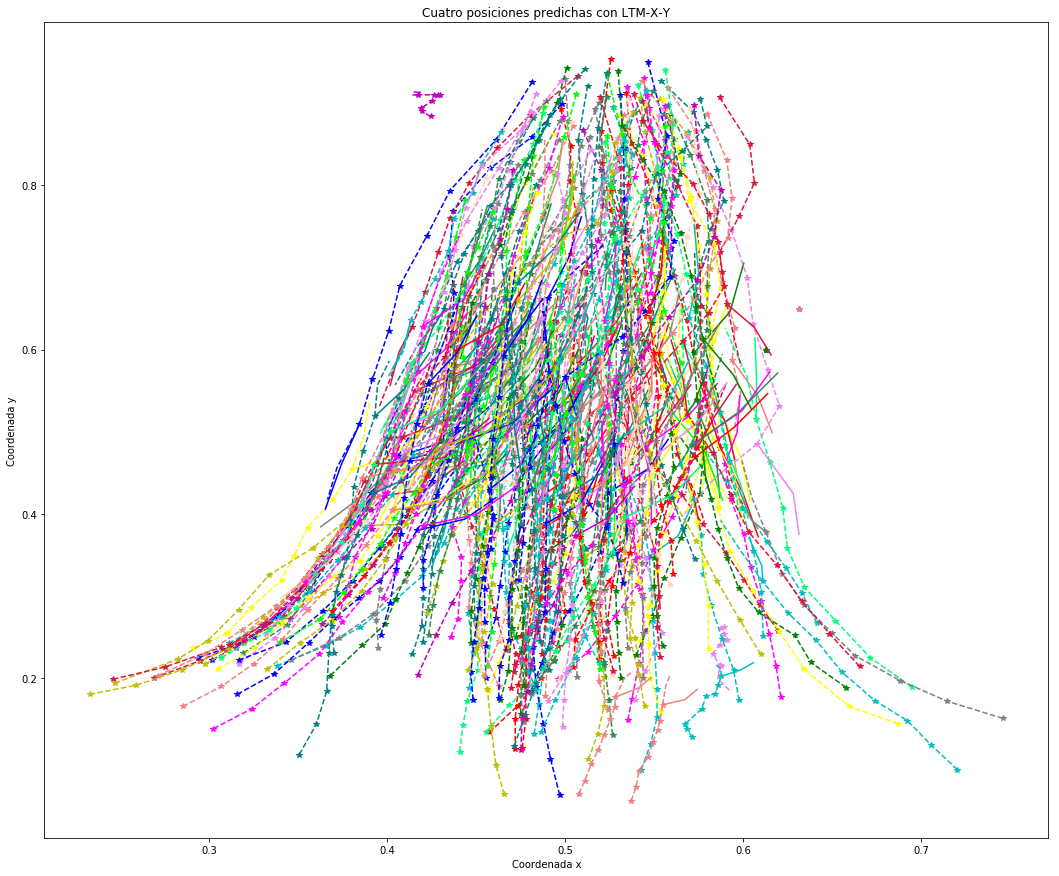

In [22]:
sample_x_persona_normalizado(datos_prueb,8,2)

('TRAYECTORIA PREDICHA DEL PEATON ', 1)
[[336.3328     457.6656    ]
 [332.9984     416.0016    ]
 [333.3312     396.9984    ]
 [336.3328     369.6672    ]
 [342.0032     351.        ]
 [343.3344     330.3312    ]
 [346.336      311.3328    ]
 [348.         293.0016    ]
 [354.76226807 272.21345901]
 [359.53689575 253.94239426]]
TRAYECTORIA VERDADERA  
[[336.3328 457.6656]
 [332.9984 416.0016]
 [333.3312 396.9984]
 [336.3328 369.6672]
 [342.0032 351.    ]
 [343.3344 330.3312]
 [346.336  311.3328]
 [348.     293.0016]
 [348.6656 276.9984]
 [351.0016 263.0016]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 10.098 
ERROR DE DESPLAZAMIENTO FINAL ES =12.447
('TRAYECTORIA PREDICHA DEL PEATON ', 2)
[[355.6672     426.        ]
 [359.0016     411.        ]
 [359.3344     387.3312    ]
 [357.3312     366.3312    ]
 [356.9984     345.        ]
 [355.6672     326.3328    ]
 [354.336      306.9984    ]
 [352.9984     288.        ]
 [356.24969482 270.03682137]
 [356.91131592 251.16428375]]
TRAY

('TRAYECTORIA PREDICHA DEL PEATON ', 21)
[[330.6688     428.6688    ]
 [334.0032     401.3328    ]
 [332.9984     375.9984    ]
 [332.6656     354.9984    ]
 [335.6672     333.6672    ]
 [339.0016     312.        ]
 [338.336      293.0016    ]
 [338.336      272.6688    ]
 [343.69773865 252.12532997]
 [346.1076355  232.21946239]]
TRAYECTORIA VERDADERA  
[[330.6688 428.6688]
 [334.0032 401.3328]
 [332.9984 375.9984]
 [332.6656 354.9984]
 [335.6672 333.6672]
 [339.0016 312.    ]
 [338.336  293.0016]
 [338.336  272.6688]
 [340.     249.    ]
 [345.3312 230.0016]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 3.596 
ERROR DE DESPLAZAMIENTO FINAL ES =2.350
('TRAYECTORIA PREDICHA DEL PEATON ', 22)
[[341.9968     417.        ]
 [349.664      386.6688    ]
 [354.336      357.6672    ]
 [359.0016     330.9984    ]
 [363.6672     305.3328    ]
 [366.6688     279.9984    ]
 [371.0016     255.        ]
 [375.6672     230.6688    ]
 [383.93592834 203.97231102]
 [389.36447144 178.67052555]]
TRAY

('TRAYECTORIA PREDICHA DEL PEATON ', 43)
[[312.         426.4992    ]
 [308.4992     408.        ]
 [301.8304     387.168     ]
 [296.4992     363.9984    ]
 [290.336      341.0016    ]
 [282.8352     321.        ]
 [274.5024     300.9984    ]
 [264.4992     279.8352    ]
 [261.81865692 261.92484856]
 [254.44770813 242.19351768]]
TRAYECTORIA VERDADERA  
[[312.     426.4992]
 [308.4992 408.    ]
 [301.8304 387.168 ]
 [296.4992 363.9984]
 [290.336  341.0016]
 [282.8352 321.    ]
 [274.5024 300.9984]
 [264.4992 279.8352]
 [260.3328 261.4992]
 [253.4976 239.0016]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 2.438 
ERROR DE DESPLAZAMIENTO FINAL ES =3.330
('TRAYECTORIA PREDICHA DEL PEATON ', 44)
[[332.         432.4992    ]
 [325.4976     407.3328    ]
 [323.0016     382.3344    ]
 [314.5024     359.0016    ]
 [307.0016     338.1648    ]
 [297.8304     318.9984    ]
 [290.5024     299.0016    ]
 [284.6656     280.8336    ]
 [279.33712006 261.24687195]
 [272.51501083 242.83407211]]
TRAY

('TRAYECTORIA PREDICHA DEL PEATON ', 65)
[[307.6672      88.3344    ]
 [311.5008     105.        ]
 [315.6672     122.1648    ]
 [321.4976     135.4992    ]
 [327.5008     153.        ]
 [332.3328     169.6656    ]
 [334.8352     186.3312    ]
 [335.5008     204.4992    ]
 [349.51332092 218.03977489]
 [356.99508667 235.60662746]]
TRAYECTORIA VERDADERA  
[[307.6672  88.3344]
 [311.5008 105.    ]
 [315.6672 122.1648]
 [321.4976 135.4992]
 [327.5008 153.    ]
 [332.3328 169.6656]
 [334.8352 186.3312]
 [335.5008 204.4992]
 [336.     222.8352]
 [336.832  242.0016]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 17.746 
ERROR DE DESPLAZAMIENTO FINAL ES =21.153
('TRAYECTORIA PREDICHA DEL PEATON ', 66)
[[186.0032     113.5008    ]
 [198.5024     122.1648    ]
 [206.8352     137.1648    ]
 [218.0032     153.4992    ]
 [222.336      167.3328    ]
 [227.3344     183.9984    ]
 [236.4992     200.5008    ]
 [243.3344     218.0016    ]
 [258.42922211 226.37779713]
 [270.33876419 242.52602577]]
TR

('TRAYECTORIA PREDICHA DEL PEATON ', 87)
[[312.4992     429.9984    ]
 [308.4992     401.0016    ]
 [306.8352     371.0016    ]
 [305.4976     342.9984    ]
 [306.6688     315.4992    ]
 [304.9984     291.3312    ]
 [305.4976     265.4976    ]
 [307.168      241.6656    ]
 [309.05359268 215.67425251]
 [309.73230362 190.73126793]]
TRAYECTORIA VERDADERA  
[[312.4992 429.9984]
 [308.4992 401.0016]
 [306.8352 371.0016]
 [305.4976 342.9984]
 [306.6688 315.4992]
 [304.9984 291.3312]
 [305.4976 265.4976]
 [307.168  241.6656]
 [308.     219.168 ]
 [309.9968 197.5008]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 5.212 
ERROR DE DESPLAZAMIENTO FINAL ES =6.775
('TRAYECTORIA PREDICHA DEL PEATON ', 88)
[[148.9984      86.5008    ]
 [165.664       91.8336    ]
 [182.336      101.0016    ]
 [199.0016     113.5008    ]
 [211.3344     131.5008    ]
 [223.0016     145.6656    ]
 [231.0016     165.9984    ]
 [240.         184.8336    ]
 [261.42486572 185.93997002]
 [276.78981781 202.35477448]]
TRAY

('TRAYECTORIA PREDICHA DEL PEATON ', 108)
[[317.9968     421.8336    ]
 [308.         390.9984    ]
 [298.336      365.3328    ]
 [291.6672     328.6656    ]
 [291.0016     300.        ]
 [286.5024     274.4976    ]
 [280.6656     249.4992    ]
 [275.5008     227.0016    ]
 [273.01351547 197.13894367]
 [267.06037521 172.23661423]]
TRAYECTORIA VERDADERA  
[[317.9968 421.8336]
 [308.     390.9984]
 [298.336  365.3328]
 [291.6672 328.6656]
 [291.0016 300.    ]
 [286.5024 274.4976]
 [280.6656 249.4992]
 [275.5008 227.0016]
 [270.5024 203.832 ]
 [263.0016 183.    ]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 9.326 
ERROR DE DESPLAZAMIENTO FINAL ES =11.503
('TRAYECTORIA PREDICHA DEL PEATON ', 109)
[[296.          91.5024    ]
 [289.4976     116.0016    ]
 [285.3312     137.6688    ]
 [286.0032     163.5024    ]
 [289.8304     190.4976    ]
 [297.3312     216.3312    ]
 [304.4992     241.4976    ]
 [310.5024     267.6672    ]
 [323.75221252 291.51700974]
 [336.27952576 318.00307274]]
T

('TRAYECTORIA PREDICHA DEL PEATON ', 128)
[[344.9984      83.0016    ]
 [348.832       99.9984    ]
 [354.6688     122.5008    ]
 [352.         144.4992    ]
 [348.832      166.4976    ]
 [344.6656     188.1648    ]
 [341.4976     206.5008    ]
 [338.6688     224.1648    ]
 [345.77789307 245.85393906]
 [347.76359558 266.64270401]]
TRAYECTORIA VERDADERA  
[[344.9984  83.0016]
 [348.832   99.9984]
 [354.6688 122.5008]
 [352.     144.4992]
 [348.832  166.4976]
 [344.6656 188.1648]
 [341.4976 206.5008]
 [338.6688 224.1648]
 [339.5008 245.832 ]
 [333.4976 270.4992]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 10.528 
ERROR DE DESPLAZAMIENTO FINAL ES =14.778
('TRAYECTORIA PREDICHA DEL PEATON ', 129)
[[382.5024      83.0016    ]
 [380.4992     100.8336    ]
 [376.3328     119.1648    ]
 [372.4992     138.4992    ]
 [369.664      156.9984    ]
 [368.832      179.5008    ]
 [365.4976     201.        ]
 [361.4976     221.0016    ]
 [367.23526001 239.57726955]
 [368.80004883 261.47881508]]


('TRAYECTORIA PREDICHA DEL PEATON ', 148)
[[296.          84.3312    ]
 [296.4992     102.9984    ]
 [299.6672     118.1664    ]
 [299.6672     143.1648    ]
 [301.4976     164.5008    ]
 [304.         185.1648    ]
 [306.5024     206.0016    ]
 [307.5008     228.4992    ]
 [319.44612503 246.17880821]
 [327.003479   268.31957817]]
TRAYECTORIA VERDADERA  
[[296.      84.3312]
 [296.4992 102.9984]
 [299.6672 118.1664]
 [299.6672 143.1648]
 [301.4976 164.5008]
 [304.     185.1648]
 [306.5024 206.0016]
 [307.5008 228.4992]
 [311.3344 250.4976]
 [314.6688 273.8352]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 11.351 
ERROR DE DESPLAZAMIENTO FINAL ES =13.512
('TRAYECTORIA PREDICHA DEL PEATON ', 149)
[[356.832      431.1648    ]
 [364.9984     402.        ]
 [370.8352     375.6672    ]
 [371.6672     351.4992    ]
 [371.0016     324.9984    ]
 [370.8352     299.5008    ]
 [369.1648     274.5024    ]
 [368.         251.0016    ]
 [374.20425415 226.08837605]
 [375.57571411 201.50855541]]


('TRAYECTORIA PREDICHA DEL PEATON ', 168)
[[336.6656      97.6656    ]
 [333.9968     117.4992    ]
 [333.1648     132.168     ]
 [334.8352     150.4992    ]
 [333.9968     167.5008    ]
 [338.5024     186.6672    ]
 [342.6688     204.168     ]
 [343.0016     222.9984    ]
 [352.08023071 239.60781097]
 [358.53118896 258.57430458]]
TRAYECTORIA VERDADERA  
[[336.6656  97.6656]
 [333.9968 117.4992]
 [333.1648 132.168 ]
 [334.8352 150.4992]
 [333.9968 167.5008]
 [338.5024 186.6672]
 [342.6688 204.168 ]
 [343.0016 222.9984]
 [340.832  241.6656]
 [340.832  260.0016]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 14.596 
ERROR DE DESPLAZAMIENTO FINAL ES =17.757
('TRAYECTORIA PREDICHA DEL PEATON ', 169)
[[314.6688     113.832     ]
 [314.5024     129.4992    ]
 [314.336      144.8352    ]
 [315.168      163.1664    ]
 [314.0032     182.0016    ]
 [313.1648     200.832     ]
 [314.8352     219.168     ]
 [317.9968     237.4992    ]
 [323.48197937 254.63899612]
 [328.55758667 273.8979435 ]]


('TRAYECTORIA PREDICHA DEL PEATON ', 188)
[[366.336      431.1648    ]
 [368.         401.5008    ]
 [376.         381.4992    ]
 [373.4976     354.        ]
 [367.5008     329.0016    ]
 [357.1648     306.8352    ]
 [347.168      284.3328    ]
 [337.9968     262.5024    ]
 [338.0581665  239.2946434 ]
 [331.0748291  217.52848148]]
TRAYECTORIA VERDADERA  
[[366.336  431.1648]
 [368.     401.5008]
 [376.     381.4992]
 [373.4976 354.    ]
 [367.5008 329.0016]
 [357.1648 306.8352]
 [347.168  284.3328]
 [337.9968 262.5024]
 [329.3312 239.832 ]
 [323.5008 220.6656]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 8.471 
ERROR DE DESPLAZAMIENTO FINAL ES =8.198
('TRAYECTORIA PREDICHA DEL PEATON ', 189)
[[356.         451.5024    ]
 [358.8352     419.832     ]
 [357.1648     388.1664    ]
 [353.4976     355.4976    ]
 [345.8304     323.3328    ]
 [334.1696     297.4992    ]
 [323.0016     273.        ]
 [315.3344     250.8336    ]
 [313.31903458 220.28162956]
 [304.53361511 195.54970264]]
TR

('TRAYECTORIA PREDICHA DEL PEATON ', 205)
[[344.3328     426.8352    ]
 [337.9968     408.9984    ]
 [336.9984     392.0016    ]
 [335.3344     377.0016    ]
 [331.5008     362.0016    ]
 [319.5008     354.8352    ]
 [304.4992     334.8336    ]
 [291.5008     312.        ]
 [287.23974228 305.27097702]
 [278.45655441 290.66393852]]
TRAYECTORIA VERDADERA  
[[344.3328 426.8352]
 [337.9968 408.9984]
 [336.9984 392.0016]
 [335.3344 377.0016]
 [331.5008 362.0016]
 [319.5008 354.8352]
 [304.4992 334.8336]
 [291.5008 312.    ]
 [282.1696 286.4976]
 [273.8304 261.4992]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 24.488 
ERROR DE DESPLAZAMIENTO FINAL ES =29.529
('TRAYECTORIA PREDICHA DEL PEATON ', 206)
[[254.1696     174.        ]
 [263.5008     194.5008    ]
 [270.8352     216.168     ]
 [278.336      238.6656    ]
 [284.         259.4976    ]
 [289.8304     282.168     ]
 [297.3312     303.8352    ]
 [303.0016     327.        ]
 [316.01057053 346.94812775]
 [325.22872925 368.24632645]]


('TRAYECTORIA PREDICHA DEL PEATON ', 220)
[[294.1696     368.3328    ]
 [288.4992     348.        ]
 [284.6656     333.4992    ]
 [281.3312     317.6688    ]
 [282.5024     302.0016    ]
 [283.3344     284.0016    ]
 [284.9984     264.8352    ]
 [284.4992     247.5024    ]
 [284.37885284 232.75421619]
 [284.82633591 215.2351284 ]]
TRAYECTORIA VERDADERA  
[[294.1696 368.3328]
 [288.4992 348.    ]
 [284.6656 333.4992]
 [281.3312 317.6688]
 [282.5024 302.0016]
 [283.3344 284.0016]
 [284.9984 264.8352]
 [284.4992 247.5024]
 [285.1648 230.5008]
 [287.6672 213.8352]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 2.777 
ERROR DE DESPLAZAMIENTO FINAL ES =3.167
('TRAYECTORIA PREDICHA DEL PEATON ', 221)
[[296.9984     414.9984    ]
 [289.9968     396.9984    ]
 [286.6688     379.4976    ]
 [280.         364.5024    ]
 [277.9968     345.4992    ]
 [273.1648     329.5008    ]
 [268.1664     316.1664    ]
 [264.4992     305.5008    ]
 [261.84846878 289.30864334]
 [257.66454697 276.35662079]]
TR

('TRAYECTORIA PREDICHA DEL PEATON ', 235)
[[305.1648      70.3344    ]
 [304.          86.0016    ]
 [304.1664     105.6672    ]
 [307.5008     143.1648    ]
 [307.0016     159.9984    ]
 [309.1648     180.8352    ]
 [309.1648     200.832     ]
 [308.9984     221.0016    ]
 [321.83280945 242.25623131]
 [329.17823792 263.83449554]]
TRAYECTORIA VERDADERA  
[[305.1648  70.3344]
 [304.      86.0016]
 [304.1664 105.6672]
 [307.5008 143.1648]
 [307.0016 159.9984]
 [309.1648 180.8352]
 [309.1648 200.832 ]
 [308.9984 221.0016]
 [308.     244.3344]
 [308.     266.832 ]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 17.689 
ERROR DE DESPLAZAMIENTO FINAL ES =21.389
('TRAYECTORIA PREDICHA DEL PEATON ', 236)
[[319.0016      67.3344    ]
 [319.5008      83.0016    ]
 [320.1664      98.832     ]
 [321.8304     118.8336    ]
 [322.5024     138.4992    ]
 [322.0032     156.8352    ]
 [322.0032     176.0016    ]
 [324.4992     195.9984    ]
 [333.67294312 210.16161919]
 [339.93026733 229.89253521]]


('TRAYECTORIA PREDICHA DEL PEATON ', 252)
[[193.4976      66.4992    ]
 [207.3344      78.168     ]
 [219.0016      93.168     ]
 [231.5008     110.0016    ]
 [239.8336     128.832     ]
 [248.9984     146.3328    ]
 [259.5008     165.        ]
 [268.832      185.0016    ]
 [288.06720734 191.7324543 ]
 [303.54156494 209.51653004]]
TRAYECTORIA VERDADERA  
[[193.4976  66.4992]
 [207.3344  78.168 ]
 [219.0016  93.168 ]
 [231.5008 110.0016]
 [239.8336 128.832 ]
 [248.9984 146.3328]
 [259.5008 165.    ]
 [268.832  185.0016]
 [278.8352 205.8336]
 [287.5008 227.5008]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 20.476 
ERROR DE DESPLAZAMIENTO FINAL ES =24.099
('TRAYECTORIA PREDICHA DEL PEATON ', 253)
[[342.5024     434.5008    ]
 [343.3344     398.0016    ]
 [344.9984     368.832     ]
 [344.         341.5008    ]
 [344.         314.5008    ]
 [344.832      289.4976    ]
 [348.         266.5008    ]
 [345.4976     243.6672    ]
 [351.02981567 216.32317543]
 [352.36984253 192.35748768]]


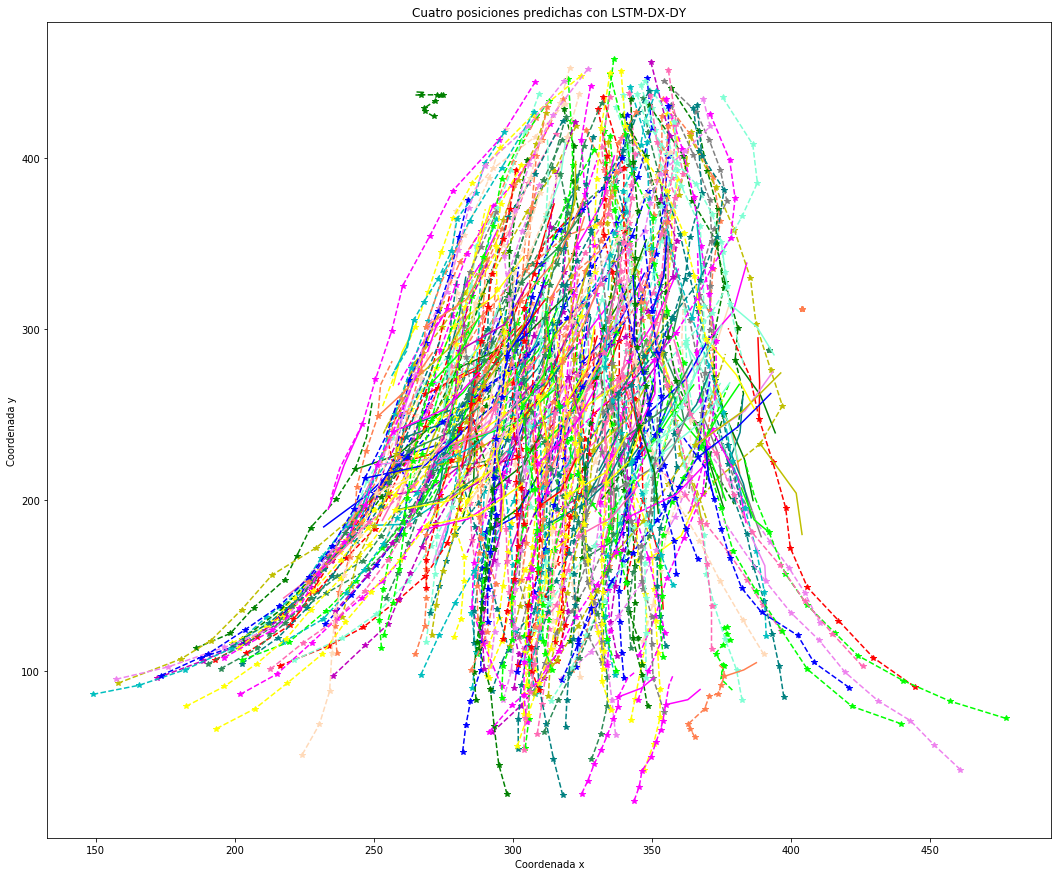

In [23]:
sample_x_persona_pixeles(datos_prueb,8,2)